In [163]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

# 전처리 & dataset 생성

In [164]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [165]:
file_dir = './8moods'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [166]:
print(imgDS.class_to_idx)

{'angry_mood': 0, 'anxiety_mood': 1, 'depressed_mood': 2, 'dynamic_mood': 3, 'happy_mood': 4, 'peaceful_mood': 5, 'tired_mood': 6, 'withered_mood': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


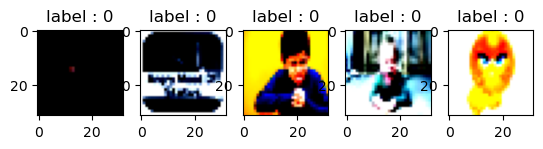

In [167]:
k = 1
for (img, label) in imgDS:
    plt.subplot(1,5,k)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"label : {label}")
    k += 1
    if k == 6 : break
plt.show()


In [168]:
seed = torch.Generator().manual_seed(42)
train, val, test = 0.7, 0.1, 0.2
trainDS, validDS, testDS = random_split(imgDS, [train, val, test], generator = seed)

# DataLoader

In [169]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size = batch_size, shuffle=True, drop_last = True)
valid_dl = DataLoader(validDS, batch_size = batch_size, shuffle=True, drop_last = True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True, drop_last = True)

1개의 배치 안에 있는 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


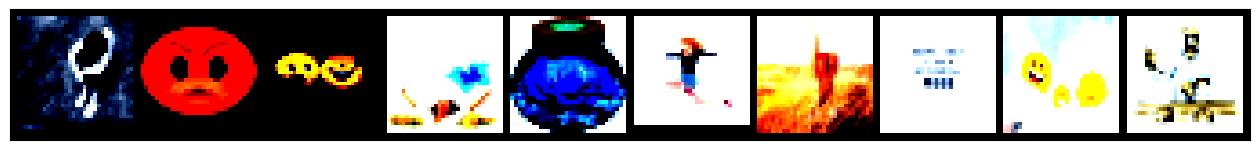

In [170]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for (images, labels) in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# 전이학습

In [171]:
# 모델 인스턴스 생성 : 사전 학습된 모델 로딩 (가중치 O)
res_model = models.resnet18(weights = "ResNet18_Weights.DEFAULT")

# 전결합층 변경
res_model.fc = nn.Linear(in_features = 512, out_features = 8)

In [172]:
# 모델의 합성곱층 가중치 고정
for param in res_model.parameters(): 
    param.requires_grad = False
for param in res_model.fc.parameters():   # 완전 연결층은 학습
    param.requires_grad = True

# 학습 위한 변수 선언

In [173]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = res_model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr은 default로 함

EPOCH = 300
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [0, EPOCH], gamma = 0.5)
# milestones => 어떤 에포크 구간에서 학습률을 조정할지 나타내는거


In [174]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 함수 만들긔

In [175]:
import torchmetrics as mt
# 배치 크기는 10 , class 개수는 8

In [176]:
def training(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        # print(feature.shape, target.shape)
        pred = model(feature)
        # print(pred.shape)
        # 손실계산
        loss = loss_fn(pred, target)

        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())
        
    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

# training(train_dl)

In [177]:
def testing(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())

    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    return total_loss, total_acc

In [178]:
save_score_point = 0.5
train_list = [[], []]
val_list = [[], []]
for epo in range(EPOCH):
    loss, acc = training(train_dl)
    train_list[0].append(loss)
    train_list[1].append(acc)
    loss, acc = testing(valid_dl)
    val_list[0].append(loss)
    val_list[1].append(acc)
    print('.', end = '')

    if epo%100 == 0 : print(epo)

    # 검증 데이터 기준 학습된 모델 저장
    if loss < save_score_point:
        torch.save(res_model, filename)
        print('  모 델 저 장 완 료\n')
        
    # 스케줄러
    scheduler.step()
print('DONE')

.0
....................................................................................................100
....................................................................................................200
...................................................................................................DONE


In [184]:
print('TRAIN')
print(f"{(sum(train_list[0])/len(train_list[0]))}")
print(f"{(sum(train_list[1])/len(train_list[1]))}")

print('VALID')
print(f"{(sum(val_list[0])/len(val_list[0]))}")
print(f"{(sum(val_list[1])/len(val_list[1]))}")

TRAIN
2.083490000000001
0.4632166666666668
VALID
2.9057666666666657
0.3549733333333334


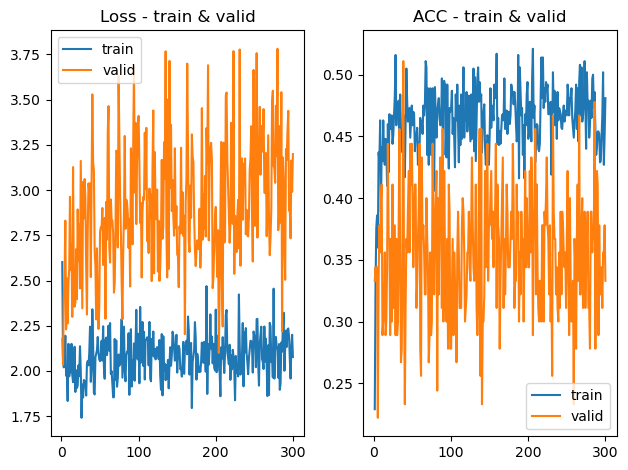

In [179]:
epo_list = [ k for k in range(1, EPOCH+1)]

plt.subplot(1,2,1)
plt.plot(epo_list, train_list[0], label = 'train')
plt.plot(epo_list, val_list[0], label = 'valid')
plt.legend()
plt.title('Loss - train & valid')

plt.subplot(1,2,2)
plt.plot(epo_list, train_list[1], label = 'train')
plt.plot(epo_list, val_list[1], label = 'valid')
plt.legend()
plt.title('ACC - train & valid')

plt.tight_layout()
plt.show()

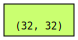

In [180]:
from torchviz import make_dot
y_pred = torch.randint(low = 0, high = 255, size = (32, 32) )
make_dot(y_pred, params = dict(model.named_parameters()))

# 예측

In [181]:
def predicting(DATALOADER):
    model.train()
    loss_list = []
    acc_list = []
    for (feature, target) in DATALOADER:
        feature = feature.to(device)
        target = target.to(device)
        pred = model(feature)

        # 손실계산
        loss = loss_fn(pred, target)

        # 성능
        accuracy = mt.Accuracy(num_classes= 8, task = 'multiclass')
        acc = accuracy(pred, target).item()
        acc_list.append(acc)
        loss_list.append(loss.item())

    total_acc = round(sum(acc_list)/len(acc_list) , 3)
    total_loss = round(sum(loss_list)/len(loss_list), 3)
    print(f"predict loss : {total_loss}   predict acc : {total_acc}")
    return total_loss, total_acc

predicting(test_dl)

predict loss : 3.274   predict acc : 0.3


(3.274, 0.3)

# 모델 저장

In [182]:
## 학습 중 모델 저장 관련 변수
dir = './model/'
filename = dir + f"res_mood_{EPOCH}.pth"
print(filename)

./model/res_mood_300.pth


In [183]:
torch.save(model.state_dict(), filename)
print('모델 저장 완료')

모델 저장 완료
